# Dimensionality Reduction

As the name says, dimensionality reduction is the idea of reducing your feature set to a much smaller number. Dimensionality reduction is often used in visualization of datasets to try and detect samples that are similar. We will cover three dimensionality reduction techniques here:

1. t-SNE
2. PCA
3. umap

In [1]:
using Pkg
Pkg.activate(".")

  Activating 

environment at `e:\Projects\julia-intro\data-science\Project.toml`


In [3]:
using UMAP
using Makie
using XLSX
using VegaDatasets
using DataFrames
using MultivariateStats
using RDatasets
using StatsBase
using Statistics
using LinearAlgebra
using Plots
using ScikitLearn
using MLBase
using Distances

We will use a dataset from the VegaDatasets package. The dataset is about car specifications of over 400 car models.

In [4]:
C = DataFrame(VegaDatasets.dataset("cars"))

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower
,String,Float64?,Int64,Float64,Int64?
1,chevrolet chevelle malibu,18.0,8,307.0,130
2,buick skylark 320,15.0,8,350.0,165
3,plymouth satellite,18.0,8,318.0,150
4,amc rebel sst,16.0,8,304.0,150
5,ford torino,17.0,8,302.0,140
6,ford galaxie 500,15.0,8,429.0,198
7,chevrolet impala,14.0,8,454.0,220
8,plymouth fury iii,14.0,8,440.0,215
9,pontiac catalina,14.0,8,455.0,225


In [5]:
dropmissing!(C)
M = Matrix(C[:,2:7])
names(C)

9-element Vector{String}:
 "Name"
 "Miles_per_Gallon"
 "Cylinders"
 "Displacement"
 "Horsepower"
 "Weight_in_lbs"
 "Acceleration"
 "Year"
 "Origin"

In [6]:
car_origin = C[:,:Origin]
carmap = labelmap(car_origin)  #from MLBase
uniqueids = labelencode(carmap, car_origin)

392-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 2
 1
 1
 1
 3
 1
 1
 1

# PCA

We will first center the data.

In [14]:
# Center and normalize the data
data = M
data = (data .- mean(data, dims=1))./ std(data,dims=1)

392×6 Matrix{Float64}:
 -0.697747   1.48205    1.07591    0.663285   0.619748   -1.28362
 -1.08212    1.48205    1.48683    1.57258    0.842258   -1.46485
 -0.697747   1.48205    1.18103    1.18288    0.539692   -1.64609
 -0.953992   1.48205    1.04725    1.18288    0.53616    -1.28362
 -0.82587    1.48205    1.02813    0.923085   0.554997   -1.82732
 -1.08212    1.48205    2.24177    2.42992    1.60515    -2.00855
 -1.21024    1.48205    2.48068    3.00148    1.62045    -2.37102
 -1.21024    1.48205    2.34689    2.87158    1.57101    -2.55226
 -1.21024    1.48205    2.49023    3.13138    1.70404    -2.00855
 -1.08212    1.48205    1.86908    2.22208    1.02709    -2.55226
  ⋮                                                       ⋮
 -0.185255   0.309571   0.359199   0.195645  -0.167864   -0.304954
  1.09597   -0.862911  -0.481748  -0.220035  -0.368005   -0.594928
  1.60847   -0.862911  -0.567753  -0.531795  -0.715308   -0.92115
  0.455359  -0.862911  -0.414854  -0.375915  -0.0324748  

PCA expects each column to be an observation, so we will use the transpose of the matrix.

In [15]:
# Each car is now a column, PCA takes features - by - samples matrix
data'

6×392 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.697747  -1.08212   -0.697747  …   1.09597    0.583482   0.967851
  1.48205    1.48205    1.48205      -0.862911  -0.862911  -0.862911
  1.07591    1.48683    1.18103      -0.567753  -0.711097  -0.720653
  0.663285   1.57258    1.18288      -0.531795  -0.661694  -0.583754
  0.619748   0.842258   0.539692     -0.803605  -0.415097  -0.303253
 -1.28362   -1.46485   -1.64609   …  -1.4286     1.10867    1.39865


First, we will fit the model via PCA. maxoutdim is the output dimensions, we want it to be 2 in this case.

In [16]:
p = fit(PCA, data', maxoutdim=2)

PCA(indim = 6, outdim = 2, principalratio = 0.919482878533357)

We can obtain the projection matrix by calling the function `projection`.

In [17]:
P = projection(p)

6×2 Matrix{Float64}:
  0.398973  -0.244835
 -0.430615   0.148314
 -0.443531   0.108497
 -0.434122  -0.166158
 -0.430103   0.286095
  0.291926   0.892652

Now that we have the projection matrix `P`, we can apply it on one car as follows:

In [18]:
P'*(data[1,:]-mean(p))

2-element Vector{Float64}:
 -2.323001696522692
 -0.5713519642644691

Or we can transform all the data via the transform function.

In [19]:
Yte = MultivariateStats.transform(p, data')   #notice that Yte[:,1] is the same as P'*(data[1,:]-mean(p))

2×392 Matrix{Float64}:
 -2.323     -3.20196  -2.66658   -2.60214   …   1.22011  1.70921   1.86951
 -0.571352  -0.68187  -0.992744  -0.621975     -1.87471  0.632857  0.815607

We can also go back from two dimensions to 6 dimensions, via the `reconstruct` function... But this time, it will be approximate.

In [20]:
# Reconstruct testing observations (approximately)
Xr = reconstruct(p, Yte)

6×392 Matrix{Float64}:
 -0.786928  -1.11055  -0.820834  …   0.945785   0.526984   0.546196
  0.91558    1.27768   1.00103      -0.803445  -0.64215   -0.684075
  0.968334   1.34619   1.075        -0.744559  -0.689425  -0.740696
  1.1034     1.50334   1.32257      -0.218179  -0.847159  -0.947116
  0.835669   1.18209   0.862883     -1.06112   -0.554079  -0.570742
 -1.18816   -1.54341  -1.66462   …  -1.31728    1.06388    1.27381

In [21]:
norm(Xr-data')  # This won't be zero

13.74384105556901

Finally, we will generate a scatter plot of the cars:

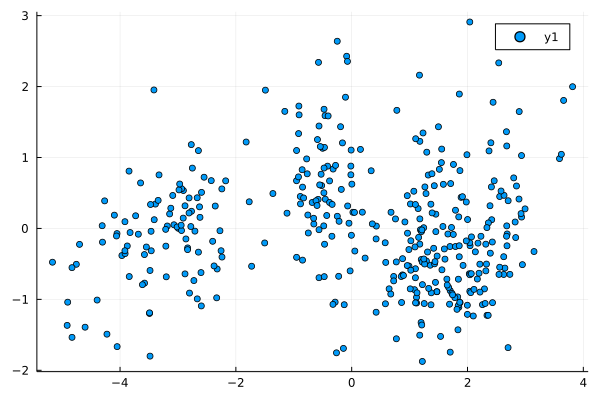

In [22]:
Plots.scatter(Yte[1,:], Yte[2,:])

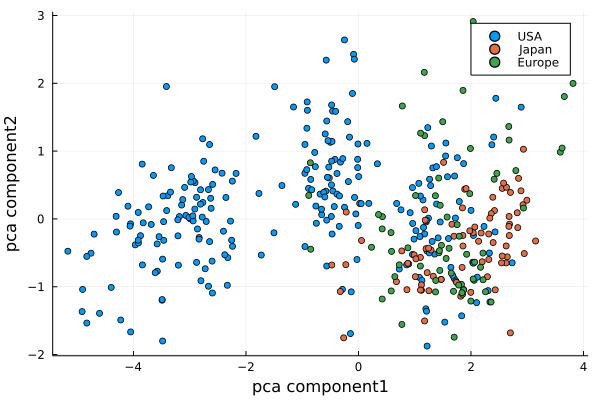

In [23]:
Plots.scatter(Yte[1,car_origin.=="USA"],Yte[2,car_origin.=="USA"],color=1,label="USA")
Plots.xlabel!("pca component1")
Plots.ylabel!("pca component2")
Plots.scatter!(Yte[1,car_origin.=="Japan"],Yte[2,car_origin.=="Japan"],color=2,label="Japan")
Plots.scatter!(Yte[1,car_origin.=="Europe"],Yte[2,car_origin.=="Europe"],color=3,label="Europe")

This is interesting! There seems to be 3 main clusters with cars from the US dominating two clusters.

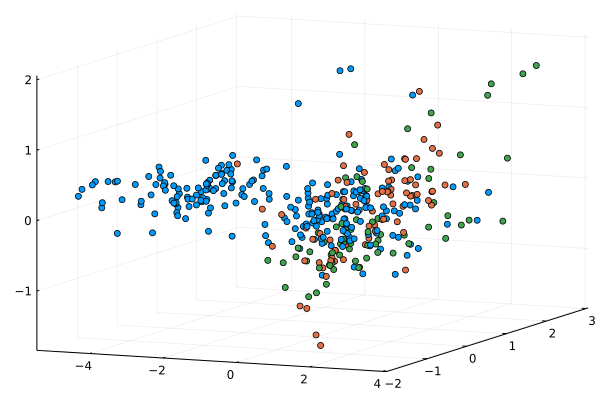

In [24]:
p = fit(PCA, data', maxoutdim=3)
Yte = MultivariateStats.transform(p, data')
scatter3d(Yte[1,:], Yte[2,:], Yte[3,:], color = uniqueids, legend = false)


This is a 3d plot, but eventhough you can set the camera view, you won't be able to move the 3d plot around. Let's use another package for this purpose. We will use Mackie.

In [ ]:
using GLMakie
scene = Makie.scatter(Yte[1,:],Yte[2,:],Yte[3,:],color=uniqueids)

# t-SNE

The next method we will use for dimensionality reduction is t-SNE. There are multiple ways you can call t-SNE from julia. Check out this notebook: https://github.com/nassarhuda/JuliaTutorials/blob/master/TSNE/TSNE.ipynb. But we will take this opportunity to try out something new... Call a function from the Scikit learn python package. This makes use of the package ScikitLearn.

┌ Info: Installing sklearn via the Conda scikit-learn package...
└ @ PyCall C:\Users\Anthony\.julia\packages\PyCall\BD546\src\PyCall.jl:711


┌ Info: Running `conda install -y scikit-learn` in root environment
└ @ Conda C:\Users\Anthony\.julia\packages\Conda\sNGum\src\Conda.jl:128


done
Solving environment: ...working... 

done



## Package Plan ##

  environment location: C:\Users\Anthony\.julia\conda\3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-1.0.1               |     pyhd8ed1ab_0         206 KB  conda-forge
    m2w64-gcc-libgfortran-5.3.0|                6         342 KB  conda-forge
    m2w64-gcc-libs-5.3.0       |                7         520 KB  conda-forge
    m2w64-gcc-libs-core-5.3.0  |                7         214 KB  conda-forge
    m2w64-gmp-6.1.0            |                2         726 KB  conda-forge
    m2w64-libwinpthread-git-5.0.0.4634.697f757|                2          31 KB  conda-forge
    msys2-conda-epoch-20160418 |                1           3 KB  conda-forge
    scikit-learn-1.0           |   py39h74df8f2_1         6.9 MB  conda-forge
    scipy-1.7.1                |   py39hc0c34ad_0        24.6 MB  conda-forge
    threadpoolc

m2w64-libwinpthread- | 31 KB     | ########## | 100% 
m2w64-gcc-libs-core- | 214 KB    |            |   0% 

m2w64-gcc-libs-core- | 214 KB    | ########## | 100% 
msys2-conda-epoch-20 | 3 KB      |            |   0% 

msys2-conda-epoch-20 | 3 KB      | ########## | 100% 
threadpoolctl-3.0.0  | 17 KB     |            |   0% 

threadpoolctl-3.0.0  | 17 KB     | ########## | 100% 
scikit-learn-1.0     | 6.9 MB    |            |   0% 

scikit-learn-1.0     | 6.9 MB    | #4         |  15% 

scikit-learn-1.0     | 6.9 MB    | ########## | 100% 
m2w64-gmp-6.1.0      | 726 KB    |            |   0% 

m2w64-gmp-6.1.0      | 726 KB    | ########## | 100% 
m2w64-gcc-libgfortra | 342 KB    |            |   0% 

m2w64-gcc-libgfortra | 342 KB    | ########## | 100% 
joblib-1.0.1         | 206 KB    |            |   0% 

joblib-1.0.1         | 206 KB    | ########## | 100% 
scipy-1.7.1          | 24.6 MB   |            |   0% 

scipy-1.7.1          | 24.6 MB   | ##1        |  22% 

scipy-1.7.1          | 24.6 MB   | ####2      |  43% 

scipy-1.7.1          | 24.6 MB   | #######8   |  78% 

scipy-1.7.1          | 24.6 MB   | ########## | 100% 
m2w64-gcc-libs-5.3.0 | 520 KB    |            |   0% 

m2w64-gcc-libs-5.3.0 | 520 KB    | ########## | 100% 
Preparing transaction: ...working... 

done
Verifying transaction: ...working... 

done
Executing transaction: ...working... 

done


C:\Users\Anthony\.julia\conda\3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Anthony\.julia\conda\3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


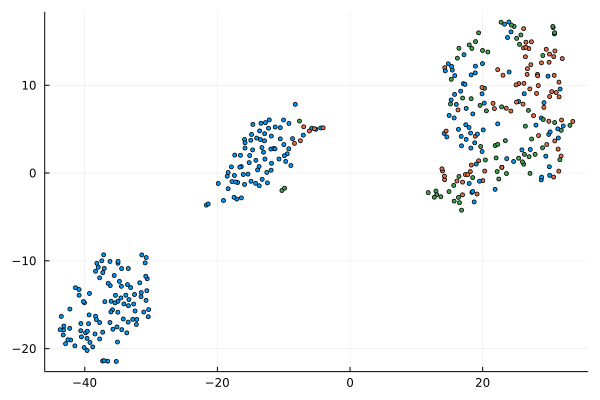

In [27]:
@sk_import manifold : TSNE 
tfn = TSNE(n_components = 2)

Y2 = tfn.fit_transform(data);
Plots.scatter(Y2[:,1], Y2[:,2], color=uniqueids, legend=false, size(400,300), markersize=3)

# UMAP

Thie will be our final dimensionality reduction method and we will use th package `UMAP` for it.

In [29]:
L = cor(data, data, dims=2)
embedding = umap(L, 2)

2×392 Matrix{Float64}:
 -7.66086  -7.25933  -8.07474  -7.48142  …   4.29638  10.2076   10.333
 -3.84143  -4.28328  -4.42732  -4.02567     -3.55821   1.57317   1.48809

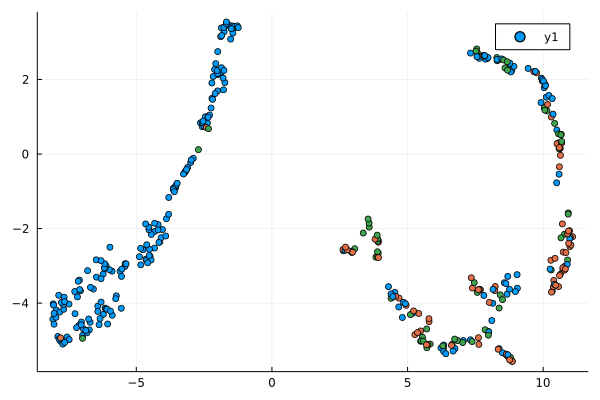

In [30]:
Plots.scatter(embedding[1,:], embedding[2,:], color = uniqueids)


For UMAP, we can create distances between every pair of observations differently, if we choose to. But even with both choices, we will see that UMAP generates a very similar pattern to what we have observed with t-SNE and PCA.

In [31]:

L = pairwise(Euclidean(), data, data,dims=1) 
embedding = umap(-L, 2)

2×392 Matrix{Float64}:
 -6.98358  -10.1234   -7.49625  -7.4357   …   7.26465    5.26736   5.4517
  2.53606    2.49729   2.18941   2.28069     -0.338732  -3.24253  -3.30182

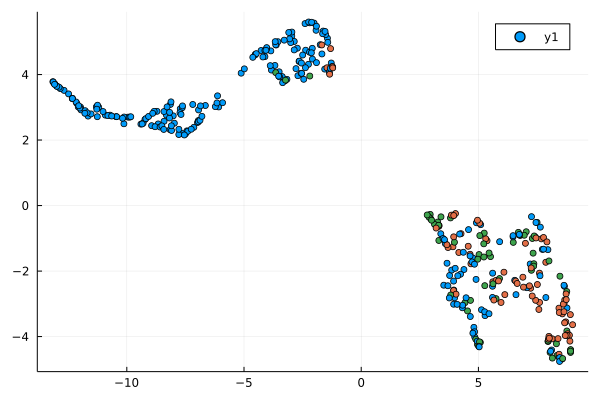

In [32]:
Plots.scatter(embedding[1,:],embedding[2,:],color=uniqueids)